# Gastric H(+)/K(+) ATPase  Activity

Note: this notebook was built in Google Colab so it is optimized for such use.


## Abstract

### Introduction

With gastroparesis, a condition that can cause significant acid reflux, the only option is to treat the stomach acidity to lessen tissue damage and not the disease itself. To do this, gastric H,K-ATPase, the protein that is primarily responsible for making stomach bile acidic, must be inhibited to lessen the damage any aspirate may do to the rest of the body. One way to find potentially effective compounds is through creating a machine learning mdoel that can predict the inhibitive effect of chemical compounds.

### Methods

236 known inhibitors of gastric H,K-ATPase were drawn from the ChemBL database, including measured IC50 values and molecular information. Each inhibitor was placed through the PaDEL descriptor software to gather 881 descriptors for each molecule, then descriptors with low variance($ < 20\% $) were removed. The remaining dataset, with its 121 features, was pushed through lazypredict to find the highest performing regression model. This model was then hyperparameterized with GridSearchCV.

### Results

Scikit-learn's k-nearest neighbors regression model was the best performming model with a default $r^2$ values of 0.56 and a hyperparameterized $r^2$ value of 0.59 with a mean absolute error percantage of 22.4%. The issues with this model can primarily be placed at the feet of the relatively low number of samples compared to features, causing a relatively high amount of variability in the model. More experiments with separate drug molecules are needed to create a model 

### Next Steps

The next step is to deploy the trained LGBMRegressor model so other prospective models can be tested. When completed, a link can be found >here<. 


## Introduction

### Project Context

In cases where patients suffer from severe gastroparesis (delayed gastric emptying), patients may aspirate significantly and cause damage to their soft tissues, most crucially their lungs. As there are no commercial options for curing gastroparesis, one potential way to help patients with their symptoms is by making their aspirate less acidic. As stomach bile is made acidic through the gastric H/K ATPase proton pump, this is the ideal target for inhibitors. 

The purpose of this project is to investigate how various machine learning models can be used to look for potentially effective drugs. 

### Personal Context

I decided to do this project as a way to showcase personal knowledge and ability. I specifically decided to do gastric H/K ATPase as I worked on a senior design project on creating devices that limits aspiration in patients with gastroparesis, so I am aware of the clinical relevance of this project. Inspiration for performing a computational drug discovery project comes from Chanin Nantasenamat, who runs a YouTube channel titled the 'Data Professor'. 

## Methods

The overall gameplan is the following:
1. Download and augment the data as needed
2. Perform exploratory analysis of the data
3. Investigate various models
4. Hyperparameterize the best performing model
5. If the best performming mdoel is not a decision tree, attempt to hyperparameterize that. 


### Acquiring Molecular Bioactivity Data

To get the necessary bioactivity data, we will need access to [ChEMBL](https://www.ebi.ac.uk/chembl/). ChEMBL is a database run by the European Molecular Biology Laboratory that holds the chemical, bioactivity, and genomic information for bioactive molecules with drug-like properties. We can interact with it using the [chembl_webresource_client](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4489243/), which we will need to pip install. 

In [ ]:
! pip install chembl_webresource_client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


For the first part of this notebook, we will need to interact with ChEMBL as a dataframe, requiring the need to import pandas and numpy in conjunction with the recently pip-installed chembl_webresource_client. 

In [ ]:
# importing libraries
import pandas as pd
import numpy as np
from chembl_webresource_client.new_client import new_client

With the necessary libraries imported, we can move to the next step in acquiring the data for gastric H/K ATPase from ChEMBL. This protein pump has the id [CHEMBL2095173](https://www.ebi.ac.uk/chembl/target_report_card/CHEMBL2095173/). With this information, we can download the $IC_{50}$ values of gastric H/K ATPase when inhibited by various drugs. This data is an analgamation of different sets of experimental data all tested on the same tissue with the same criteria/rules, but ChEMBL is nice enough to save the data for public use. For those who do not know what $IC_{50}$ is, it is the amount of a drug/molecule necessary to inhibit a biological process by 50%, typically expressed in moles of drug or molar concentration of drug. The data we are investigating is completely in micromoles.

In [ ]:
# go into the ChEMBL database, use CHEMBLID to find protein, and get IC50 values
target = new_client.target
chembl_id = 'CHEMBL2095173'
protein_activity = new_client.activity
res = protein_activity.filter(target_chembl_id = chembl_id).filter(type = 'IC50')

In [ ]:
# transforming the dictionary into a dataframe
df = pd.DataFrame.from_dict(res)
df

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,185453,[],CHEMBL690673,Inhibition of H+/K+ ATPase activity in buffere...,B,None,None,BAO_0000190,BAO_0000223,...,Homo sapiens,Potassium-transporting ATPase,9606,None,None,IC50,uM,UO_0000065,None,98.0
1,None,196324,[],CHEMBL690673,Inhibition of H+/K+ ATPase activity in buffere...,B,None,None,BAO_0000190,BAO_0000223,...,Homo sapiens,Potassium-transporting ATPase,9606,None,None,IC50,uM,UO_0000065,None,100.0
2,None,205980,[],CHEMBL690673,Inhibition of H+/K+ ATPase activity in buffere...,B,None,None,BAO_0000190,BAO_0000223,...,Homo sapiens,Potassium-transporting ATPase,9606,None,None,IC50,uM,UO_0000065,None,100.0
3,None,213023,[],CHEMBL690673,Inhibition of H+/K+ ATPase activity in buffere...,B,None,None,BAO_0000190,BAO_0000223,...,Homo sapiens,Potassium-transporting ATPase,9606,None,None,IC50,uM,UO_0000065,None,33.0
4,None,216494,[],CHEMBL690673,Inhibition of H+/K+ ATPase activity in buffere...,B,None,None,BAO_0000190,BAO_0000223,...,Homo sapiens,Potassium-transporting ATPase,9606,None,None,IC50,uM,UO_0000065,None,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,None,1253722,[],CHEMBL686816,Compound was tested in vitro for H+/K+ ATPase ...,B,None,None,BAO_0000190,BAO_0000221,...,Homo sapiens,Potassium-transporting ATPase,9606,None,None,IC50,uM,UO_0000065,None,100.0
297,None,1256438,[],CHEMBL686816,Compound was tested in vitro for H+/K+ ATPase ...,B,None,None,BAO_0000190,BAO_0000221,...,Homo sapiens,Potassium-transporting ATPase,9606,None,None,IC50,uM,UO_0000065,None,4.8
298,None,1258991,[],CHEMBL686816,Compound was tested in vitro for H+/K+ ATPase ...,B,None,None,BAO_0000190,BAO_0000221,...,Homo sapiens,Potassium-transporting ATPase,9606,None,None,IC50,uM,UO_0000065,None,100.0
299,None,1258993,[],CHEMBL686816,Compound was tested in vitro for H+/K+ ATPase ...,B,None,None,BAO_0000190,BAO_0000221,...,Homo sapiens,Potassium-transporting ATPase,9606,None,None,IC50,uM,UO_0000065,None,14.0


We'll start with removing non-na values in the 'standard values'(IC50) column. After that, we'll remove non-unique chemical values, keeping the first instance that is reported of each molecule. This will take the number of rows from 301 to 236 unique molecules. 

In [ ]:
# initial number of molecules
df.shape[0]

301

In [ ]:
# removing molecules with no IC50 and that are repeated in the dataset
df2 = df[df.standard_value.notna()]
df2 = df2.drop_duplicates(['molecule_chembl_id'])
df2.shape[0]

236

With only unique molecules with data now, we will snatch the columns we want and turn them into appropriate data types. The columns we are keeping are the molecule ID, the molecule's canonical SMILE (simplified molecular-input line-entry system), and its IC50 activity value. For those who do not know what a SMILE is, it is essentially a way to see a molecule's chemical formula in a 1-dimensional fashion. The IC50 activity level is then turned into a float data type. 

In [ ]:
# making dataframe with molecule identifiers and IC50 value
df3 = df2.loc[:,['molecule_chembl_id','canonical_smiles','standard_value']]
df3.loc[:,'standard_value'] = df3['standard_value'].astype(float)
df3.reset_index(drop = True, inplace = True)
df3

,molecule_chembl_id,canonical_smiles,standard_value
0,CHEMBL54932,COc1c(C)cnc(CCC2(C)Nc3ccccc3S2)c1C,98000.00
1,CHEMBL58203,COc1c(C)cnc(CCC2(C)Nc3cc(Cl)ccc3S2)c1C,100000.00
2,CHEMBL433094,COc1c(C)cnc(/C=C/C2(C)Nc3ccccc3S2)c1C,100000.00
3,CHEMBL58681,COc1c(C)cnc(CCC2(C)Nc3cc(F)ccc3S2)c1C,33000.00
4,CHEMBL57148,COc1c(C)cnc(CCC2(C)Nc3cc(C(F)(F)F)ccc3S2)c1C,24000.00
...,...,...,...
231,CHEMBL97122,COc1cccc2c1ncc1c(C(C)C)cn(-c3ccc(O)cc3C)c12,7200.00
232,CHEMBL97334,COc1cccc2c1ncc1c(CO)cn(-c3ccc(F)cc3C)c12,100000.00
233,CHEMBL327653,Cc1ccccc1-n1cc(C)c2cnc3c(O)cccc3c21,4800.00
234,CHEMBL317569,COc1cccc2c1ncc1c(CO)cn(-c3ccccc3C)c12,100000.00


The next step for the machine learning setup process is to transform the IC50 values from uM to the -log10 of the IC50, also known as the pIC50. 


In [ ]:
# transforming IC50(um) to pIC50
def pIC50(IC50_Level):

  pIC50 = []
  
  # for each IC50, transform to Molar and convert to pIC50
  for IC50 in IC50_Level:
    pIC50.append(-np.log10(IC50 * 10**-6))

  # add pIC50 values to dataframe 
  df3['pIC50'] = pIC50
  return df3

In [ ]:
df4 = pIC50(df3['standard_value'])
df4

,molecule_chembl_id,canonical_smiles,standard_value,pIC50
0,CHEMBL54932,COc1c(C)cnc(CCC2(C)Nc3ccccc3S2)c1C,98000.00,1.01
1,CHEMBL58203,COc1c(C)cnc(CCC2(C)Nc3cc(Cl)ccc3S2)c1C,100000.00,1.00
2,CHEMBL433094,COc1c(C)cnc(/C=C/C2(C)Nc3ccccc3S2)c1C,100000.00,1.00
3,CHEMBL58681,COc1c(C)cnc(CCC2(C)Nc3cc(F)ccc3S2)c1C,33000.00,1.48
4,CHEMBL57148,COc1c(C)cnc(CCC2(C)Nc3cc(C(F)(F)F)ccc3S2)c1C,24000.00,1.62
...,...,...,...,...
231,CHEMBL97122,COc1cccc2c1ncc1c(C(C)C)cn(-c3ccc(O)cc3C)c12,7200.00,2.14
232,CHEMBL97334,COc1cccc2c1ncc1c(CO)cn(-c3ccc(F)cc3C)c12,100000.00,1.00
233,CHEMBL327653,Cc1ccccc1-n1cc(C)c2cnc3c(O)cccc3c21,4800.00,2.32
234,CHEMBL317569,COc1cccc2c1ncc1c(CO)cn(-c3ccccc3C)c12,100000.00,1.00


The next part of the setup process is classifying/binning the different drugs based off their IC50 levels for exploratory analysis. Drugs with less than 1000 um IC50 values will be labeled as low. Drugs with greater than 1000 um and less than 10000 um will be labeled as medium levels. Drugs with greater than 10000 um will be labeled as high. This results in an almost equal distribution of activity levels. 

### Using Molecular Descriptors to Gather Features

Right now we have the names of the molecules and the target pIC50 value for each molecule. However, we have no features! To get features, we will use a program called PaDEL-Decriptor to calculate molecular descriptors and fingerprints for use in the dataset. More information can be found [here](https://onlinelibrary.wiley.com/doi/10.1002/jcc.21707). All we need to know right now is that the program takes the ChEMBL Id and the Molecular SMILE and uses it to find over 800 features about the molecule, and all of those features are binary. 

For now, we will need to download, unzip, and push the molecule name/smiles through the software.

In [ ]:
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh

--2022-09-30 18:42:28--  https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip [following]
--2022-09-30 18:42:28--  https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25768637 (25M) [application/zip]
Saving to: ‘padel.zip.1’

padel.zip.1         100%[===================>]  24.57M  --.-KB/s    in 0.1s    

2022-09-30 18:42:29 (165 MB/s) - ‘padel.zip.1’ saved [25768637/25768637]

--2022-09-30 18:42:29--  https://gi

In [ ]:
! unzip padel.zip

Archive:  padel.zip
replace __MACOSX/._PaDEL-Descriptor? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
molecule_names_df = df4[['canonical_smiles','molecule_chembl_id']]
molecule_names_df.to_csv('molecule.smi',sep='\t',index = False, header = False)

In [ ]:
# proving that the molecule file is good for use
! cat molecule.smi | head -5 

COc1c(C)cnc(CCC2(C)Nc3ccccc3S2)c1C	CHEMBL54932
COc1c(C)cnc(CCC2(C)Nc3cc(Cl)ccc3S2)c1C	CHEMBL58203
COc1c(C)cnc(/C=C/C2(C)Nc3ccccc3S2)c1C	CHEMBL433094
COc1c(C)cnc(CCC2(C)Nc3cc(F)ccc3S2)c1C	CHEMBL58681
COc1c(C)cnc(CCC2(C)Nc3cc(C(F)(F)F)ccc3S2)c1C	CHEMBL57148


In [ ]:
# getting length of molecule.smi
! cat molecule.smi | wc -l

236


In [ ]:
! cat padel.sh

java -Xms1G -Xmx1G -Djava.awt.headless=true -jar ./PaDEL-Descriptor/PaDEL-Descriptor.jar -removesalt -standardizenitro -fingerprints -descriptortypes ./PaDEL-Descriptor/PubchemFingerprinter.xml -dir ./ -file descriptors_output.csv


In [ ]:
! bash padel.sh

Processing CHEMBL54932 in molecule.smi (1/236). 
Processing CHEMBL58203 in molecule.smi (2/236). 
Processing CHEMBL433094 in molecule.smi (3/236). Average speed: 2.54 s/mol.
Processing CHEMBL58681 in molecule.smi (4/236). Average speed: 1.30 s/mol.
Processing CHEMBL57148 in molecule.smi (5/236). Average speed: 1.16 s/mol.
Processing CHEMBL1503 in molecule.smi (6/236). Average speed: 0.97 s/mol.
Processing CHEMBL1744200 in molecule.smi (7/236). Average speed: 0.89 s/mol.
Processing CHEMBL1203526 in molecule.smi (8/236). Average speed: 0.78 s/mol.
Processing CHEMBL1203474 in molecule.smi (9/236). Average speed: 0.69 s/mol.
Processing CHEMBL1202256 in molecule.smi (10/236). Average speed: 0.74 s/mol.
Processing CHEMBL1203510 in molecule.smi (12/236). Average speed: 0.65 s/mol.
Processing CHEMBL108285 in molecule.smi (11/236). Average speed: 0.66 s/mol.
Processing CHEMBL108610 in molecule.smi (14/236). Average speed: 0.58 s/mol.
Processing CHEMBL422329 in molecule.smi (13/236). Average spe

In [ ]:
! ls -l

total 50800
-rw-r--r-- 1 root root   430797 Sep 30 18:43 descriptors_output.csv
drwx------ 6 root root     4096 Sep 30 17:01 drive
drwxr-xr-x 3 root root     4096 Sep 30 17:15 __MACOSX
-rw-r--r-- 1 root root    13466 Sep 30 18:42 molecule.smi
drwxrwxr-x 4 root root     4096 May 30  2020 PaDEL-Descriptor
-rw-r--r-- 1 root root      231 Sep 30 17:15 padel.sh
-rw-r--r-- 1 root root      231 Sep 30 18:42 padel.sh.1
-rw-r--r-- 1 root root 25768637 Sep 30 17:15 padel.zip
-rw-r--r-- 1 root root 25768637 Sep 30 18:42 padel.zip.1
drwxr-xr-x 1 root root     4096 Sep 26 13:45 sample_data


### Preparing Dataset for Machine Learning

With PaDEL Descriptors created, we can move to the next step, which is doing machine learning preparations.

In [260]:
X = pd.read_csv('descriptors_output.csv').drop(columns = ['Name'])
X.shape

(236, 881)

We are going to remove columns that have 80% consitstency in values.WSince the columns only contain boolean values, we can utilize the following formula for the variance threshold: 
\begin{equation}
  \text{Var}|X| = p(1-p),
\end{equation}
where p is the probability of containing only one varaible. 

In [261]:
from sklearn.feature_selection import VarianceThreshold
selection = VarianceThreshold(threshold = 0.8*(1-0.8) )
X = selection.fit_transform(X)
X.shape

(236, 121)

This leaves us with 121 features and 236 molecules. We are going to need to save the column names for our app so we know what features we care about.

In [273]:
X_df = pd.DataFrame(columns = selection.get_feature_names_out())
featurefilepath = "./drive/MyDrive/GastricActivity/featuredata.csv"
X_df.to_csv(featurefilepath, index = False)

As we will see in the next code block, all features are already binary so we do not need to perform any more preprocessing with the features. 

In [ ]:
np.unique(X)

array([0, 1])

The desired output is the pIC50 values. 

In [258]:
Y = df4['pIC50']
Y.shape

(236,)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 42)

## Exploratory Analysis

Before we continue any further, we are going to perform some exploratory analysis with some of the variables. 

In [ ]:
conditions = {
    "Low": df3['standard_value'] < 1000,
    "Medium": (df3['standard_value'] >= 1000) & (df3['standard_value'] <=10000) ,
    "High": df3['standard_value'] > 10000
}
df3['Class'] = np.select(conditions.values(),conditions.keys())

df3['Class'].value_counts()

Medium    94
Low       74
High      68
Name: Class, dtype: int64

To determine the drug-like qualities of each molecule, we will use Lipinksi's rule of 5, which is a rule of thumb for if a molecule is orally active. With this, there are four criteria: i). No more than 5 hydrogen bond donors, ii). No more than 10 hydrogen bond acceptors, iii). MW of less than 500 Da, and iV). an octanol-water coefficient of less than 5. 

To do this, we will need to import the RDKit library, a python/c++ library with chemoinformatics information, such as lipinski, for various molecules. 

In [ ]:
! pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# import numpy and rdkit tools
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

In [ ]:
def lipinski(smiles):
  molecule_data = []

  for element in smiles:
    molecule = Chem.MolFromSmiles(element)
    molecule_data.append(molecule)
  
  i = 0
  molecule_info_df = pd.DataFrame(columns = ['H Donors','H Acceptors','MW','LogP'])

  for molecule in molecule_data:
    MoleculeHDonors = Chem.Lipinski.NumHDonors(molecule)
    MoleculeHAcceptors = Chem.Lipinski.NumHAcceptors(molecule)    
    MolecularWeight = Chem.Descriptors.MolWt(molecule)
    MolecularLogP = Chem.Descriptors.MolLogP(molecule)

    row = pd.Series([MoleculeHDonors, MoleculeHAcceptors,
                    MolecularWeight,MolecularLogP], 
                    index = molecule_info_df.columns)
    
    molecule_info_df.loc[len(molecule_info_df)] = row



  return molecule_info_df 

In [ ]:
df_lip = lipinski(df4['canonical_smiles'])
df_lip

,H Donors,H Acceptors,MW,LogP
0,1.00,4.00,314.45,4.57
1,1.00,4.00,348.90,5.23
2,1.00,4.00,312.44,4.65
3,1.00,4.00,332.44,4.71
4,1.00,4.00,382.45,5.59
...,...,...,...,...
231,1.00,4.00,346.43,5.32
232,1.00,4.00,336.37,4.13
233,1.00,3.00,288.35,4.50
234,1.00,4.00,318.38,3.99


Now with the molecular information dataframe, we can concatenate this with the original drug molecule dataframe. 

In [ ]:
molecule_df = pd.concat([df4,df_lip], axis = 1)
molecule_df['LogP'].describe()

count   236.00
mean      4.08
std       1.63
min       0.60
25%       2.85
50%       3.79
75%       5.19
max       7.96
Name: LogP, dtype: float64

## Determining the Best Machine Learning Algorithm

There are various regression algorithms and methods that can be used, including random forest algorithms, support vector regression, and linear regression. One way to figure out which is the best way is to quickly test and see which one functions the best under basic conditions! Lazypredict is a library that provides a method to test multiple regression models at the same time. 

In [ ]:
! pip install lazypredict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import lazypredict
from lazypredict.Supervised import LazyRegressor

In [ ]:
reg = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, Y_train, Y_test)

100%|██████████| 42/42 [00:08<00:00,  4.72it/s]

[18:44:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
RANSACRegressor,14471381270519221321728.00,-22784727957838776762368.00,136397792665.42,0.41
LinearRegression,13797288192812139937792.00,-21723389920597837348864.00,133183129969.62,0.02
TransformedTargetRegressor,13797288192812139937792.00,-21723389920597837348864.00,133183129969.62,0.03
Lars,1297718658986816569344.00,-2043216612021796601856.00,40845350184.09,0.08
KernelRidge,6.95,-8.36,2.76,0.02
GaussianProcessRegressor,3.61,-3.10,1.83,0.03
QuantileRegressor,1.65,-0.03,0.92,0.50
LassoLars,1.64,-0.01,0.91,0.02
Lasso,1.64,-0.01,0.91,0.02


As we can see in the table above, some models perform really poorly and have a negative $R^2$ value. We will have to fix this when graphing and simply make those $R^2$ values equal to 0. 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

[(0.0, 1.0)]

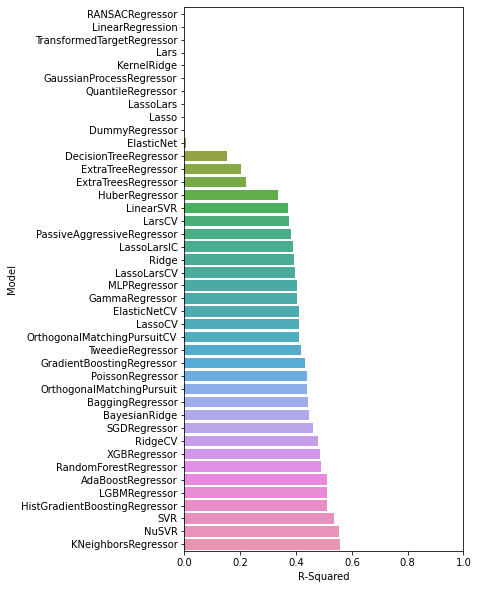

In [ ]:
models["R-Squared"] = [0 if i < 0 else i for i in models.loc[:,"R-Squared"]]

plt.figure(figsize = (5,10))
result = sns.barplot(x = "R-Squared", y = predictions.index, data = predictions)
result.set(xlim = (0,1)) 

As we can see in the above graph, the k-nearest neighbors regression model was the most accurate at an R^2 value of 0.56. This is not too great, but is expected with the limited amount of inhibition data we have for this protein.  

## Best Performing Model - K-Nearest Neighbors

With LazyPredictor showing that gradient boosting for regression, under default parameters, is the best performing model, we are going to try and hyperparameterize this model. To find the right parameters, we are going to utilize sklearn's GridSearchCV function. 

In [281]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
import pickle

In [283]:
# grid parameters to go through and options to choose from
grid_params = {
    'n_neighbors': list(range(1,15)),
    'weights' : ['uniform','distance'],
    'metric' : ['euclidean', 'manhattan','cosine','minkowski'],
    'leaf_size' : list(range(1,50)), 
    'p' : [1,2], 
    'algorithm' :  ['ball_tree','kd_tree']
}

# grid search function
gs = GridSearchCV(KNeighborsRegressor(), grid_params, scoring = 'r2', verbose = 1, cv = 3)

# fitting potential parameters to the model
gs_result = gs.fit(X, Y)

# best parameters
print(gs_result.best_params_)

Fitting 3 folds for each of 21952 candidates, totalling 65856 fits
{'algorithm': 'kd_tree', 'leaf_size': 5, 'metric': 'euclidean', 'n_neighbors': 6, 'p': 1, 'weights': 'uniform'}


In [288]:
knn = KNeighborsRegressor(n_neighbors = 6, algorithm = 'kd_tree', leaf_size = 5, metric = 'euclidean')
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)

In [289]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
knn_r2 = knn.score(X_test, Y_test)
rows, cols = X_test.shape
knn_adjr2 = 1-((1-knn_r2)*(rows-1))/(rows-cols-1)
print('R-Squared: ', knn_r2)
print('Mean Absolute Error: ', mean_absolute_error(Y_test, Y_pred))
print('Mean Squared Error: ', mean_squared_error(Y_test,Y_pred))
mape = np.mean(np.abs((Y_test - Y_pred) / np.abs(Y_test)))
print('Mean Absolute Percentage Error: ', mape*100, "percent")

R-Squared:  0.5912312683937833
Mean Absolute Error:  0.46288260295212513
Mean Squared Error:  0.33377092639911243
Mean Absolute Percentage Error:  22.39095260383438 percent


<function matplotlib.pyplot.show(*args, **kw)>

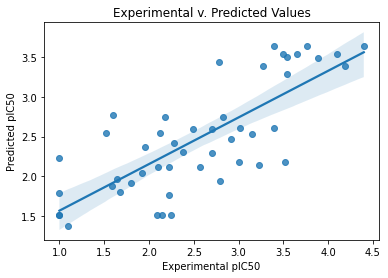

In [290]:
result = sns.regplot(x = Y_test,y = Y_pred)
result.set_xlabel('Experimental pIC50')
result.set_ylabel('Predicted pIC50')
result.set_title('Experimental v. Predicted Values')
plt.show

Since we know this is the best performing method under these parameters, we are going to save this model to create an interactive app.

In [291]:
pickle.dump(knn, open('./drive/MyDrive/GastricActivity/gastricactivity_knn_model.pkl','wb'))